# Necessary Steps

In [1]:
#!pip install -U ultralytics

In [3]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
from random import choice
import re
import csv
import pandas as pd
import glob
import math
import geopandas as gpd
from shapely.geometry import shape, Polygon
from ultralytics import YOLO
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
cd /home/core-stack/Documents/Ponds

/content/drive/MyDrive/Pond/YoLoV11/Wells


In [5]:
pwd = os.getcwd()
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Wells'

# Roboflow Download Data

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Wells'

In [ ]:
!pip install roboflow

In [ ]:
with open('.roboflow_credentials.json','r') as f:
    file = json.load(f)
    roboflow_key = file['ROBOFLOW_API_KEY']

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_key)
project = rf.workspace("ahi-7tpvv").project("wells-y7rkl")
version = project.version(1)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Wells-1 in yolov11:: 100%|██████████| 1217/1217 [00:08<00:00, 147.87it/s]


# Visualize

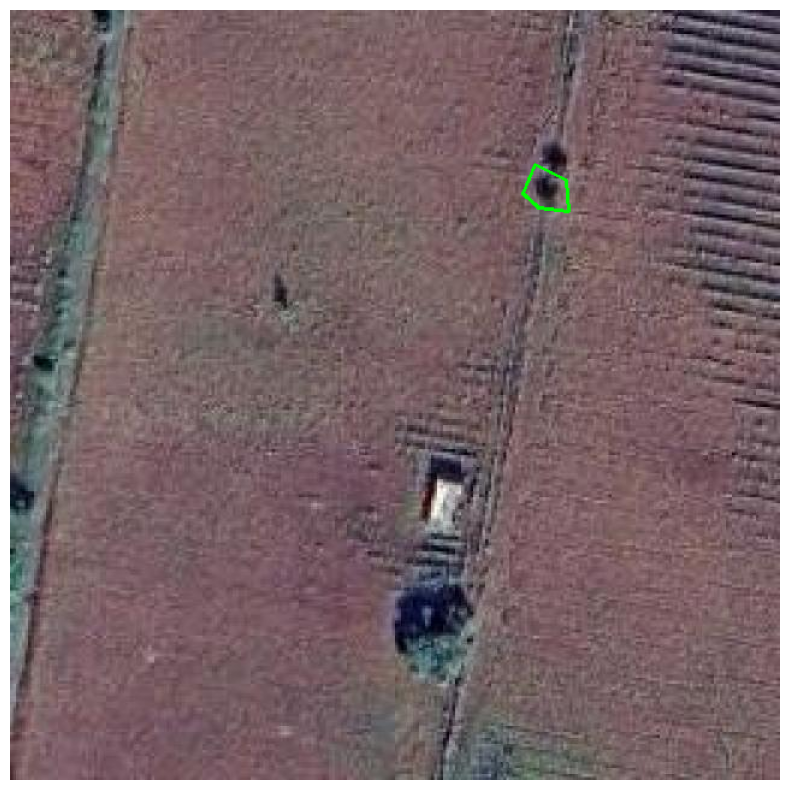

In [ ]:
annotation_file_path = "data/train/labels/tile_Akola__20-60981918_77-23723149_0_18_187314_115729_png.rf.5cd129b4ec5fa70cab795824808f9c7d.txt"
annotation_file_path = os.path.join(pwd, annotation_file_path)
image_file_path = "data/train/images/tile_Akola__20-60981918_77-23723149_0_18_187314_115729_png.rf.5cd129b4ec5fa70cab795824808f9c7d.jpg"
image_file_path = os.path.join(pwd, image_file_path)

# Check if the files exist
if not os.path.exists(image_file_path):
    raise FileNotFoundError(f"Image file not found: {image_file_path}")
if not os.path.exists(annotation_file_path):
    raise FileNotFoundError(f"Annotation file not found: {annotation_file_path}")

# Read the image
image = cv2.imread(image_file_path)
if image is None:
    raise ValueError(f"Failed to read image from file: {image_file_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get the image dimensions
image_height, image_width = image.shape[:2]

# Read the annotation file
with open(annotation_file_path, 'r') as f:
    annotations = f.readlines()

# Define a function to draw polygons on the image
def draw_polygons(image, annotations, img_width, img_height):
    for annotation in annotations:
        parts = annotation.strip().split()
        class_index = int(parts[0])
        points = list(map(float, parts[1:]))
        # Scale the normalized coordinates to the image dimensions
        scaled_points = [int(points[i] * img_width if i % 2 == 0 else points[i] * img_height) for i in range(len(points))]
        # Create a list of (x, y) tuples
        polygon = [(scaled_points[i], scaled_points[i+1]) for i in range(0, len(scaled_points), 2)]
        polygon = np.array(polygon, np.int32)
        polygon = polygon.reshape((-1, 1, 2))
        # Draw the polygon on the image
        cv2.polylines(image, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)
    return image

# Draw the annotations on the image
image_with_annotations = draw_polygons(image, annotations, image_width, image_height)

# Display the image with annotations
plt.figure(figsize=(10, 10))
plt.imshow(image_with_annotations)
plt.axis('off')
plt.show()

# Model Training

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Wells'

In [ ]:
# Load a model
model = YOLO("yolo11x-seg.yaml")  # build a new model from YAML
model = YOLO("yolo11x-seg.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11x-seg.yaml").load("yolo11x.pt")  # build from YAML and transfer weights

Transferred 1015/1077 items from pretrained weights


In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#Define a project --> Destination directory for all results
project = "Wells_results"
#Define subdirectory for this specific training
name = "100epochs_noAlbumentations" #note that if you run the training again, it creates a directory: 200_epochs-2

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Train the model
results = model.train(data="data.yaml",
                      project=project,
                      name=name,
                      epochs=100,
                      patience=0, #I am setting patience=0 to disable early stopping.
                      batch=2,
                      imgsz=256,
                      augment=False
                      )

Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11x-seg.yaml, data=data.yaml, epochs=100, time=None, patience=0, batch=2, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=Wells_results, name=100epochs_noAlbumentations, exist_ok=False, pretrained=yolo11x.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 143MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Pond/YoLoV11/Wells/data/train/labels.cache... 544 images, 4 backgrounds, 0 corrupt: 100%|██████████| 544/544 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Pond/YoLoV11/Wells/data/val/labels.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]


Plotting labels to Wells_results/100epochs_noAlbumentations/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to Wells_results/100epochs_noAlbumentations
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.43G      2.388      3.508      2.451      1.201          4        256: 100%|██████████| 272/272 [00:48<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.51it/s]

                   all         60         76     0.0187      0.461     0.0118    0.00499     0.0174      0.408     0.0102    0.00384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.87G      2.275      2.862       1.92      1.176          1        256: 100%|██████████| 272/272 [00:42<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.53it/s]

                   all         60         76     0.0339      0.618     0.0299     0.0118     0.0287      0.632     0.0244    0.00777



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.91G       2.46       3.02      2.187      1.243          9        256: 100%|██████████| 272/272 [00:42<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.78it/s]

                   all         60         76      0.261      0.421      0.222      0.082      0.233      0.408      0.182     0.0609



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100       1.9G      2.394      2.918      2.084      1.234          2        256: 100%|██████████| 272/272 [00:41<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.63it/s]

                   all         60         76      0.355      0.526       0.36      0.102      0.281      0.474      0.244     0.0712



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.91G      2.239       2.58      1.891      1.145          2        256: 100%|██████████| 272/272 [00:42<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.43it/s]

                   all         60         76      0.634      0.632      0.659      0.274      0.626      0.618      0.618      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.91G      2.195      2.591      1.899       1.14          6        256: 100%|██████████| 272/272 [00:42<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.98it/s]

                   all         60         76      0.689      0.618      0.638      0.285      0.608      0.579      0.541      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.91G      2.111       2.46      1.784      1.113          4        256: 100%|██████████| 272/272 [00:41<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.00it/s]

                   all         60         76      0.865      0.658      0.813      0.349      0.807      0.618      0.757      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100       1.9G      2.075      2.403      1.715      1.107          6        256: 100%|██████████| 272/272 [00:41<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.22it/s]

                   all         60         76      0.687      0.697      0.679      0.281       0.62      0.632       0.57      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100       1.9G      2.126      2.486       1.74      1.101          1        256: 100%|██████████| 272/272 [00:41<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.66it/s]

                   all         60         76      0.789      0.688      0.771      0.334      0.743      0.648       0.73      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.91G      2.087      2.551      1.701      1.116          3        256: 100%|██████████| 272/272 [00:41<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.92it/s]

                   all         60         76      0.717      0.697      0.743      0.315      0.579      0.684      0.659      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.93G      2.082      2.477      1.764       1.07          1        256: 100%|██████████| 272/272 [00:41<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.88it/s]

                   all         60         76      0.766      0.776      0.827      0.366       0.75      0.633       0.71      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100       1.9G      2.036      2.382      1.707      1.083          0        256: 100%|██████████| 272/272 [00:40<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.32it/s]

                   all         60         76      0.821      0.666      0.812      0.393      0.765      0.618      0.738      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.92G      2.047      2.444      1.559      1.087          2        256: 100%|██████████| 272/272 [00:41<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.62it/s]

                   all         60         76      0.826      0.686      0.817      0.391      0.779      0.684       0.78      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.91G      1.985      2.345      1.567      1.087          4        256: 100%|██████████| 272/272 [00:41<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.04it/s]

                   all         60         76      0.861      0.724      0.855      0.339      0.588      0.605      0.659      0.249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.91G      2.025      2.393       1.57      1.085          3        256: 100%|██████████| 272/272 [00:41<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.23it/s]

                   all         60         76      0.272      0.658      0.252      0.095      0.205      0.738      0.194     0.0702



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.91G      2.012      2.295      1.559      1.094          5        256: 100%|██████████| 272/272 [00:41<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.03it/s]

                   all         60         76      0.324      0.763       0.31      0.141      0.282      0.645      0.261     0.0988



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.92G      1.912       2.31      1.551      1.044          9        256: 100%|██████████| 272/272 [00:41<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.15it/s]

                   all         60         76      0.603      0.816      0.658      0.278      0.519      0.737      0.538      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.91G      1.903      2.241      1.467      1.039          3        256: 100%|██████████| 272/272 [00:41<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.99it/s]

                   all         60         76       0.86      0.727      0.847      0.391      0.768      0.655      0.754       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.92G      1.886       2.17      1.343      1.031          4        256: 100%|██████████| 272/272 [00:41<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.03it/s]

                   all         60         76      0.659       0.75      0.689      0.299      0.695      0.605      0.647      0.215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100       1.9G      1.954      2.278      1.402      1.053          7        256: 100%|██████████| 272/272 [00:41<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.48it/s]

                   all         60         76      0.372      0.553       0.35      0.134      0.345      0.513      0.307      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.91G      1.905      2.225      1.445      1.047          2        256: 100%|██████████| 272/272 [00:41<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.72it/s]

                   all         60         76      0.257      0.776       0.24      0.107      0.216      0.724        0.2     0.0716



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.91G      1.891      2.251      1.449      1.032          5        256: 100%|██████████| 272/272 [00:41<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.08it/s]

                   all         60         76      0.782      0.708      0.739      0.291      0.693      0.623      0.595      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100       1.9G      1.909      2.124      1.402      1.048          2        256: 100%|██████████| 272/272 [00:41<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.40it/s]

                   all         60         76      0.775      0.815      0.857      0.402      0.737      0.775      0.807      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.91G       1.88      2.155      1.437      1.033          7        256: 100%|██████████| 272/272 [00:41<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.79it/s]

                   all         60         76      0.847      0.802      0.842      0.354      0.632      0.684      0.601      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.91G      1.861      2.185      1.421      1.028          6        256: 100%|██████████| 272/272 [00:41<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.99it/s]

                   all         60         76      0.827      0.697      0.818      0.359      0.785      0.658      0.744      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100       1.9G      1.868       2.22      1.425      1.022          2        256: 100%|██████████| 272/272 [00:40<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.04it/s]

                   all         60         76      0.785      0.882      0.893      0.466      0.773      0.868      0.872      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.91G      1.755      2.045      1.433     0.9789          4        256: 100%|██████████| 272/272 [00:41<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.41it/s]

                   all         60         76      0.804      0.789      0.826        0.4      0.788      0.776      0.825      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.91G      1.835      2.113      1.355      1.013          5        256: 100%|██████████| 272/272 [00:40<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.60it/s]

                   all         60         76       0.85      0.747      0.798      0.284      0.627      0.532      0.539      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100       1.9G      1.845       2.05      1.272      1.026         10        256: 100%|██████████| 272/272 [00:41<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.55it/s]

                   all         60         76      0.802      0.842      0.886      0.391      0.643       0.75      0.704      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.91G      1.797      2.111      1.279      1.014          0        256: 100%|██████████| 272/272 [00:41<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.06it/s]

                   all         60         76      0.854      0.848      0.884      0.393      0.749       0.75      0.743      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.91G      1.846      2.069       1.25      1.033          4        256: 100%|██████████| 272/272 [00:41<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.38it/s]

                   all         60         76      0.911      0.882      0.936      0.405      0.784      0.764      0.815      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100       1.9G      1.872      2.187       1.34      1.048          0        256: 100%|██████████| 272/272 [00:41<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.24it/s]

                   all         60         76       0.89      0.853      0.902       0.39      0.822      0.816      0.813      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100       1.9G      1.848      2.129       1.35      1.025          7        256: 100%|██████████| 272/272 [00:40<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.88it/s]

                   all         60         76      0.856      0.781      0.862      0.388      0.872      0.697      0.781      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100       1.9G      1.788      2.108       1.23      1.004          2        256: 100%|██████████| 272/272 [00:40<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.76it/s]

                   all         60         76      0.864      0.882      0.906      0.426      0.768      0.789      0.797      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100       1.9G      1.793       1.99      1.259      1.003          5        256: 100%|██████████| 272/272 [00:42<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.86it/s]

                   all         60         76      0.888      0.727      0.862      0.403      0.775      0.635      0.749      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100       1.9G      1.826      2.242      1.267      1.022          2        256: 100%|██████████| 272/272 [00:41<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.83it/s]

                   all         60         76      0.907      0.842      0.901      0.404      0.824      0.763      0.815      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.91G      1.777      2.023      1.202      1.018          3        256: 100%|██████████| 272/272 [00:40<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.82it/s]

                   all         60         76      0.911      0.882      0.925      0.449      0.841      0.816      0.851       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.91G      1.781       2.07      1.235      1.003          4        256: 100%|██████████| 272/272 [00:41<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.13it/s]

                   all         60         76      0.843      0.777      0.869      0.387      0.718      0.669      0.684      0.264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100       1.9G      1.823      2.229      1.253      1.023          2        256: 100%|██████████| 272/272 [00:40<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.18it/s]

                   all         60         76      0.911      0.882      0.919      0.409      0.841      0.816      0.814      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.92G      1.781      2.045      1.251      1.013          3        256: 100%|██████████| 272/272 [00:40<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.24it/s]

                   all         60         76      0.806      0.767        0.8      0.345      0.753      0.697      0.707      0.252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100       1.9G      1.827      2.125      1.235      1.025          7        256: 100%|██████████| 272/272 [00:40<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.31it/s]

                   all         60         76      0.817      0.763      0.808      0.326      0.651      0.637       0.62      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100       1.9G      1.827       2.14      1.304      1.013          4        256: 100%|██████████| 272/272 [00:40<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.76it/s]

                   all         60         76      0.824      0.802      0.816      0.351      0.727       0.75      0.721      0.256



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.91G      1.735      2.032       1.24     0.9909          1        256: 100%|██████████| 272/272 [00:40<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.84it/s]

                   all         60         76      0.866      0.842      0.897      0.368      0.728      0.724      0.721      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.91G       1.78      2.058      1.249      1.009         10        256: 100%|██████████| 272/272 [00:40<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.38it/s]

                   all         60         76      0.846      0.711      0.786      0.312      0.608      0.658      0.597      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.91G      1.786      2.066      1.264     0.9967          4        256: 100%|██████████| 272/272 [00:40<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.30it/s]

                   all         60         76      0.858      0.842      0.893       0.41      0.776      0.776      0.794        0.3



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100       1.9G      1.831      2.121      1.211      1.034          6        256: 100%|██████████| 272/272 [00:40<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.73it/s]

                   all         60         76      0.906      0.908      0.923      0.408      0.821      0.829      0.804      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100       1.9G      1.671      1.957      1.104     0.9856          7        256: 100%|██████████| 272/272 [00:40<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.32it/s]

                   all         60         76      0.892      0.866      0.914      0.456      0.807      0.829      0.832      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100       1.9G      1.725      2.004      1.139      1.001          1        256: 100%|██████████| 272/272 [00:40<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.30it/s]

                   all         60         76      0.884      0.868      0.926      0.428       0.81      0.816      0.836      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100       1.9G      1.717      1.967      1.175     0.9865          3        256: 100%|██████████| 272/272 [00:39<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.72it/s]

                   all         60         76      0.889      0.847      0.913      0.445      0.862      0.822      0.876      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100       1.9G      1.758      2.007      1.123     0.9968          3        256: 100%|██████████| 272/272 [00:40<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.42it/s]

                   all         60         76      0.877      0.855       0.93      0.475      0.801      0.776      0.824       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100       1.9G      1.757      2.005      1.175     0.9785          3        256: 100%|██████████| 272/272 [00:40<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.40it/s]

                   all         60         76      0.909       0.92      0.928      0.459      0.838      0.818      0.834       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.91G      1.825      2.075      1.184      1.037          4        256: 100%|██████████| 272/272 [00:40<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.22it/s]

                   all         60         76      0.959      0.842      0.925      0.471      0.914      0.803      0.851      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.91G      1.743      2.035      1.123     0.9917          3        256: 100%|██████████| 272/272 [00:41<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.55it/s]

                   all         60         76      0.908      0.855      0.906      0.436      0.847      0.803      0.811      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.91G      1.721      2.072      1.157      1.007          4        256: 100%|██████████| 272/272 [00:40<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.44it/s]

                   all         60         76       0.89      0.855      0.923      0.439      0.804      0.776      0.817      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100       1.9G      1.799      2.082      1.113      1.025          4        256: 100%|██████████| 272/272 [00:40<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.89it/s]

                   all         60         76      0.926      0.824      0.931      0.487      0.911      0.811      0.915      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.91G      1.783      2.063      1.198          1          5        256: 100%|██████████| 272/272 [00:40<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.92it/s]

                   all         60         76      0.845      0.792      0.907      0.381      0.677      0.789      0.804      0.288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.91G      1.684      2.001      1.127     0.9708          6        256: 100%|██████████| 272/272 [00:40<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.44it/s]

                   all         60         76      0.865      0.882      0.937      0.494      0.811      0.829      0.867      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100       1.9G      1.761      2.024      1.129     0.9975          6        256: 100%|██████████| 272/272 [00:40<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.02it/s]

                   all         60         76      0.905      0.842      0.921      0.407      0.764      0.724      0.739      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.91G      1.727      2.029      1.152     0.9838          4        256: 100%|██████████| 272/272 [00:40<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.45it/s]

                   all         60         76      0.881      0.877      0.929      0.377      0.789      0.786      0.796      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.91G      1.717       1.94      1.091     0.9775         11        256: 100%|██████████| 272/272 [00:40<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.26it/s]

                   all         60         76      0.879      0.868      0.915      0.422      0.845       0.79      0.876      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.91G      1.694      1.937      1.117     0.9688          3        256: 100%|██████████| 272/272 [00:40<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.66it/s]

                   all         60         76       0.83      0.855       0.87      0.388      0.779      0.803       0.78      0.298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.91G      1.679      1.972        1.1     0.9788          6        256: 100%|██████████| 272/272 [00:39<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.71it/s]

                   all         60         76       0.92      0.912      0.931      0.408      0.815      0.809      0.785      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.92G      1.746      1.971      1.093      0.999          4        256: 100%|██████████| 272/272 [00:39<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.56it/s]

                   all         60         76      0.897      0.816      0.919      0.383      0.795      0.789      0.819      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100       1.9G       1.67      1.945      1.052     0.9829          1        256: 100%|██████████| 272/272 [00:39<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.84it/s]

                   all         60         76      0.921      0.922      0.946       0.45      0.869      0.871      0.895      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100       1.9G      1.714      2.023      1.101     0.9868          5        256: 100%|██████████| 272/272 [00:39<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.50it/s]

                   all         60         76      0.905       0.88      0.937      0.407      0.818      0.816      0.825      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100       1.9G      1.702      1.945       1.09     0.9798          3        256: 100%|██████████| 272/272 [00:39<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.82it/s]

                   all         60         76      0.918      0.885       0.92       0.41      0.851      0.825      0.834      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100       1.9G      1.732      1.944      1.081     0.9794          5        256: 100%|██████████| 272/272 [00:39<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.57it/s]

                   all         60         76      0.896      0.792       0.86      0.368       0.82      0.737      0.748      0.252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100       1.9G      1.705      2.009      1.052     0.9774          6        256: 100%|██████████| 272/272 [00:40<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.23it/s]

                   all         60         76      0.908      0.855      0.918       0.45      0.834      0.791      0.826      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100       1.9G      1.677      1.905      1.075     0.9662          4        256: 100%|██████████| 272/272 [00:39<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.67it/s]

                   all         60         76      0.917      0.855      0.934      0.469      0.836      0.804      0.839      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100       1.9G      1.678      1.924      1.068       0.98          4        256: 100%|██████████| 272/272 [00:39<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.95it/s]

                   all         60         76      0.925       0.81      0.911      0.409      0.835      0.732      0.778      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100       1.9G      1.663      1.995       1.01     0.9782          3        256: 100%|██████████| 272/272 [00:39<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.81it/s]

                   all         60         76      0.921      0.882      0.946      0.394       0.82      0.789      0.768      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.91G      1.637      1.896      1.023     0.9575          1        256: 100%|██████████| 272/272 [00:39<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.70it/s]

                   all         60         76      0.887      0.855      0.901      0.416      0.816      0.789      0.812       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.91G      1.653      1.914     0.9924     0.9838          6        256: 100%|██████████| 272/272 [00:39<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.64it/s]

                   all         60         76      0.895        0.9      0.936       0.41      0.792      0.804      0.774      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100       1.9G      1.677      1.974      0.994     0.9862          3        256: 100%|██████████| 272/272 [00:39<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.35it/s]

                   all         60         76      0.907      0.908      0.918      0.355      0.774      0.776      0.729      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.91G      1.768      2.016      1.066      1.009          1        256: 100%|██████████| 272/272 [00:39<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.44it/s]

                   all         60         76      0.896      0.908      0.918      0.471      0.845      0.858      0.866      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.91G      1.692      1.964      1.073     0.9593          3        256: 100%|██████████| 272/272 [00:40<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.33it/s]

                   all         60         76      0.887      0.931      0.902      0.388      0.812      0.854      0.813      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.91G      1.718       1.93      1.047     0.9932          7        256: 100%|██████████| 272/272 [00:40<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.63it/s]

                   all         60         76      0.845      0.816      0.867      0.371      0.758      0.737      0.703      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.92G      1.649       1.94      1.004     0.9734          1        256: 100%|██████████| 272/272 [00:40<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.22it/s]

                   all         60         76      0.889      0.895      0.911      0.425       0.82      0.816      0.803      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100       1.9G      1.646      1.936      1.027     0.9573          7        256: 100%|██████████| 272/272 [00:40<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.05it/s]

                   all         60         76      0.941      0.895      0.939       0.46      0.875      0.829       0.87      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.92G      1.627      1.877      0.958      0.967          0        256: 100%|██████████| 272/272 [00:40<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.53it/s]

                   all         60         76      0.855      0.853      0.889      0.362      0.789      0.787      0.792      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.91G      1.653      1.957      0.958          1          5        256: 100%|██████████| 272/272 [00:40<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.71it/s]

                   all         60         76      0.894      0.885      0.917      0.452      0.867      0.859      0.878      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100       1.9G      1.605      1.881     0.9612     0.9572          0        256: 100%|██████████| 272/272 [00:40<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.50it/s]

                   all         60         76      0.907      0.893      0.921      0.438      0.867      0.854      0.861      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.91G      1.588      1.811      0.966     0.9518          2        256: 100%|██████████| 272/272 [00:39<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.57it/s]

                   all         60         76      0.875      0.829      0.889      0.406      0.792      0.763      0.807      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.91G       1.58      1.871      0.929     0.9525          3        256: 100%|██████████| 272/272 [00:39<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.72it/s]

                   all         60         76      0.859      0.884      0.907      0.437      0.796      0.829      0.815      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.91G      1.636      1.894     0.9933     0.9717          3        256: 100%|██████████| 272/272 [00:40<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.90it/s]

                   all         60         76      0.911      0.921      0.948      0.452      0.871      0.882      0.896      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.91G      1.604      1.936      1.021     0.9565          5        256: 100%|██████████| 272/272 [00:40<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.29it/s]

                   all         60         76      0.898      0.882      0.928      0.425      0.815      0.803      0.804      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100       1.9G      1.608      1.891     0.9615      0.961          2        256: 100%|██████████| 272/272 [00:40<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.63it/s]

                   all         60         76      0.891      0.895      0.929      0.453      0.864      0.868      0.887       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100       1.9G      1.614      1.833     0.9772     0.9601          2        256: 100%|██████████| 272/272 [00:39<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.96it/s]

                   all         60         76      0.891      0.908      0.925      0.444      0.839      0.855      0.845       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100       1.9G      1.609      1.897     0.9196     0.9789          3        256: 100%|██████████| 272/272 [00:39<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.60it/s]

                   all         60         76      0.881      0.908      0.914      0.451      0.855      0.882      0.887      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100       1.9G      1.609      1.909       0.94     0.9676          2        256: 100%|██████████| 272/272 [00:39<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.50it/s]

                   all         60         76      0.893      0.895      0.914      0.458      0.853      0.855      0.859       0.36


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.91G      1.667      1.904     0.9079     0.9975          2        256: 100%|██████████| 272/272 [00:40<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.66it/s]

                   all         60         76      0.897      0.917      0.926      0.465      0.858      0.877      0.884      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.91G      1.608       1.92     0.8782     0.9939          2        256: 100%|██████████| 272/272 [00:39<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.92it/s]

                   all         60         76      0.903      0.908       0.92      0.447      0.864      0.868      0.871      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.91G      1.599      1.892     0.9127     0.9888          1        256: 100%|██████████| 272/272 [00:39<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.51it/s]

                   all         60         76        0.9      0.908      0.921      0.451      0.857      0.868      0.869      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100       1.9G      1.596      1.883     0.8948     0.9889          2        256: 100%|██████████| 272/272 [00:40<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.67it/s]

                   all         60         76      0.909      0.915       0.92      0.446       0.87      0.878      0.864      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.91G      1.587      1.828     0.9015     0.9894          2        256: 100%|██████████| 272/272 [00:40<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.72it/s]

                   all         60         76       0.93      0.934      0.945      0.459      0.891      0.895      0.891      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100       1.9G      1.558      1.859      0.889      0.975          2        256: 100%|██████████| 272/272 [00:40<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.73it/s]

                   all         60         76      0.917      0.921      0.922      0.458      0.891      0.895       0.89      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.91G      1.566      1.879     0.8886      0.978          3        256: 100%|██████████| 272/272 [00:39<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.39it/s]

                   all         60         76      0.899      0.895      0.917      0.431      0.858      0.855      0.858      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.92G      1.595      1.889     0.8772     0.9812          2        256: 100%|██████████| 272/272 [00:39<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.32it/s]

                   all         60         76      0.898      0.895      0.914      0.436      0.858      0.855      0.861      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100       1.9G      1.549      1.821     0.8807     0.9647          4        256: 100%|██████████| 272/272 [00:39<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.40it/s]

                   all         60         76      0.898      0.895      0.911      0.436      0.871      0.868      0.881       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100       1.9G      1.608      1.905     0.8792     0.9925          2        256: 100%|██████████| 272/272 [00:39<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 12.55it/s]

                   all         60         76      0.902      0.908      0.914      0.436      0.862      0.868       0.86      0.348



100 epochs completed in 1.230 hours.
Optimizer stripped from Wells_results/100epochs_noAlbumentations/weights/last.pt, 124.7MB
Optimizer stripped from Wells_results/100epochs_noAlbumentations/weights/best.pt, 124.7MB

Validating Wells_results/100epochs_noAlbumentations/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11x-seg summary (fused): 491 layers, 62,003,283 parameters, 0 gradients, 318.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 14.77it/s]


                   all         60         76      0.926      0.824      0.931      0.486      0.911      0.811      0.916      0.425
Speed: 0.1ms preprocess, 11.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to Wells_results/100epochs_noAlbumentations


lr/pg0,█████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
lr/pg1,▃▆███▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
lr/pg2,▆████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▁▁
metrics/mAP50(B),▁▆▇▆▇▇▇▃▃▇█▇█▇██▇████████▇█▇████▇███████
metrics/mAP50(M),▁▅▅▆▆▅▇▂▁▅▇█▅▇▇█▆▅▇▇▇█▇▇▇▇██▇▇▇▇▇▆▇▇████
metrics/mAP50-95(B),▁▂▅▅▆▆▇▇▆▂▇▅▃▅▆▇▆▆▆▆▇▇█▆█▆▇▆▇▆▇▇█▆▇▇▇▇▇█
metrics/mAP50-95(M),▁▁▄▅▆▂▄▄▂▁▆▆▅▆▆▆▇▅▄▆▇▇▇▇█▆▆▆▆▅▇▆▇▆▆▇▇▆▇█
metrics/precision(B),▂▇▅▆▁▂▁▆▇▆█▇▇█▇▇▇▇▇██▇▇▇▇▇█▇▇█▇▇▇▇█▇▇▇▇█
metrics/precision(M),▁▁▃▃▆▇▇▇▇▅▄▃▇▇█▇▆▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇███████
metrics/recall(B),▂▃▃▅▃▃▅▄▅▁▄▆▇▅▅▆▇▇▄▆▇▆▇▆█▇▆█▇▇█▆▇▇▇████▇
metrics/recall(M),▁▂▄▄▅▅▄▄▃▅█▆▃▆▅▇▇▅▄▅▇▇▇▇▆▇▇▇▆▆▆▇▇▇▇█████
